In [12]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('../data/final_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) 
df.dropna(inplace=True)

# Using close and sentiment score
data = df[['Close', 'EMA_10', 'SMA_10', 'MACD', 'MACD_Signal', 'RSI', 'avg_sentiment', 'Volume']].values

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [14]:
def create_sequences(data, window_size):
    x, y = [], []
    for i in range(len(data) - window_size):
        x.append(data[i:i + window_size])
        y.append(data[i + window_size][0]) # Close price is the target
    return np.array(x), np.array(y)

window_size = 60 
x, y = create_sequences(scaled_data, window_size)

# split the data into training and testing sets
split = int(len(x)* 0.8) # 80% of 210 samples for training
x_train, x_test = x[:split], x[split:] 
y_train, y_test = y[:split], y[split:]

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 8)) # 8 features
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 8))

Epoch 1/60


c:\Users\priya\Downloads\stock-market-prediction\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.4958 - val_loss: 0.0380
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0783 - val_loss: 0.0159
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0292 - val_loss: 0.0216
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0267 - val_loss: 0.0184
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0254 - val_loss: 0.0178
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0197 - val_loss: 0.0152
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0211 - val_loss: 0.0155
Epoch 8/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0178 - val_loss: 0.0165
Epoch 9/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0179 - val_loss: 0.0163
Epoch 10/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0173 - val_loss: 0.0193
Epoch 11/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0165 - val_loss: 0.0165
Epoch 12/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0145 - val_loss: 0.0165
Epoch 13/60


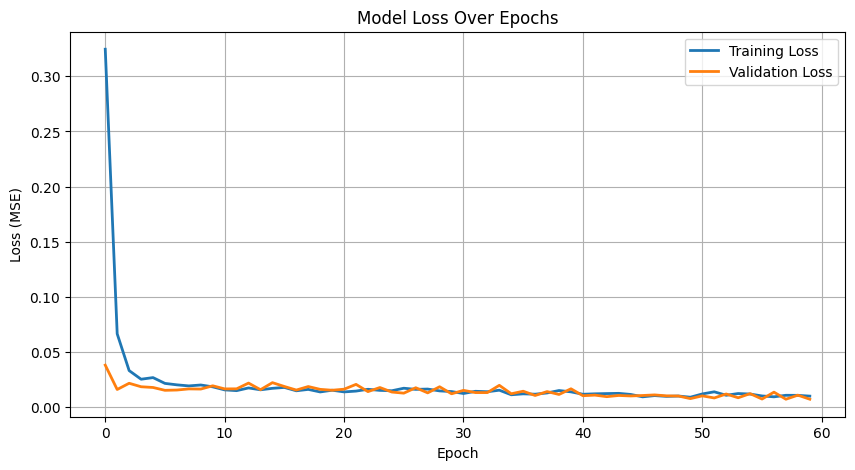

In [31]:
import tensorflow as tf 

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 8)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=60, batch_size=25, validation_data=(x_test, y_test), verbose=1)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


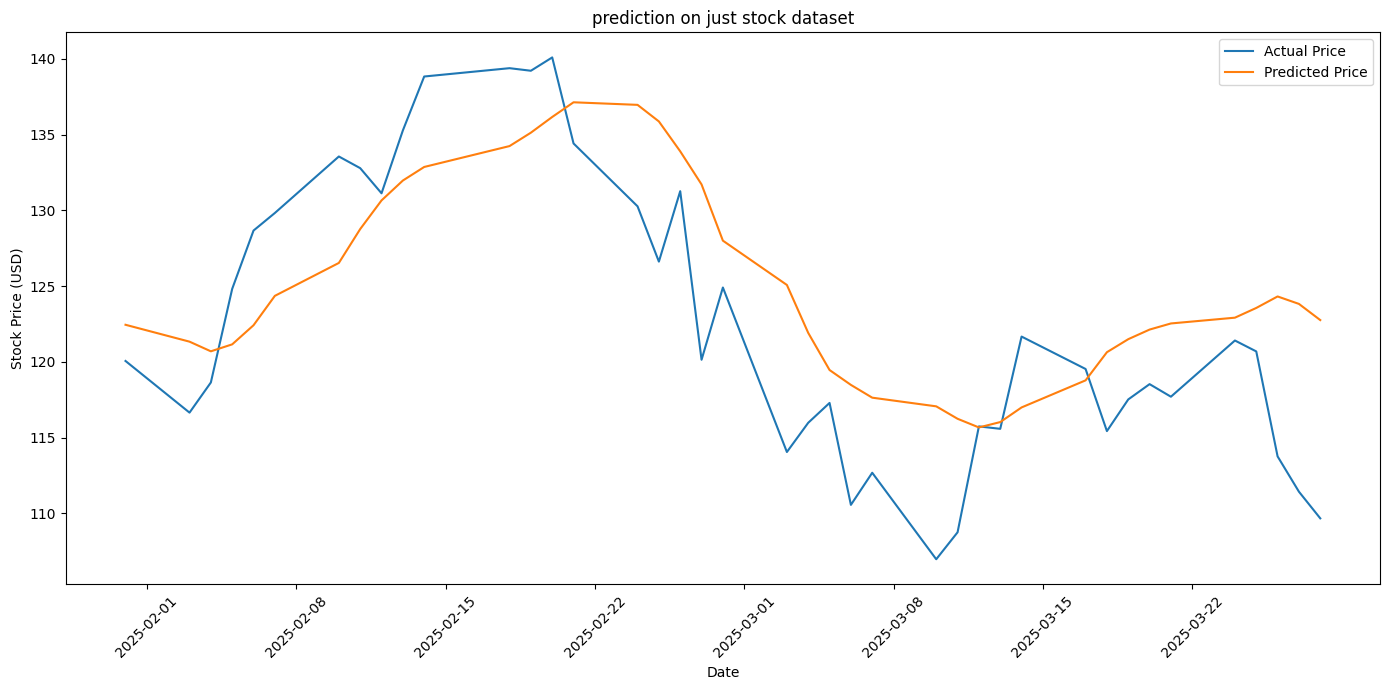

In [32]:
predicted = model.predict(x_test) #predicting based on the test set

predicted_extended = np.zeros((predicted.shape[0], 8))
predicted_extended[:, 0] = predicted[:, 0]

actual_extended = np.zeros((y_test.shape[0], 8))
actual_extended[:, 0] = y_test

predicted_inversed = scaler.inverse_transform(predicted_extended)[:, 0]
actual_inversed = scaler.inverse_transform(actual_extended)[:, 0]

test_dates = df.index[-len(y_test):]

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(test_dates, actual_inversed, label='Actual Price')
plt.plot(test_dates, predicted_inversed, label='Predicted Price')
plt.title('prediction on just stock dataset')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
model.save('../models/lstm_combined.h5')

In [34]:
import joblib
joblib.dump(scaler, '../models/scaler_combined.save')

['../models/scaler_combined.save']